In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd

In [3]:
path = '/content/drive/My Drive/drama-reviews'
reviews_csv = 'drama_reviews_processed.csv'

df = pd.read_csv(path+'/'+reviews_csv)
df.head()

,drama_title,user_name,overall_rating,story_rating,cast_rating,music_rating,rewatch_value_rating,reviews,sentiment,reviews_processed,language,reviews_processed2x,reviews_lemmatized
0,Dear My Friends (2016),iamgeralddd,10.0,10.0,10.0,10.0,10.0,Thank you writer Noh for making this heart-wa...,1,thank you writer noh for making this heart war...,en,thank writer noh making heart warming story co...,heart warming story live drama excited weekend...
1,Dear My Friends (2016),Dounie,10.0,10.0,10.0,8.5,9.0,"I know for some, stories following and tellin...",1,i know for some stories following and telling ...,en,know stories following telling lives older peo...,story old people promise boring decide try fun...
2,Dear My Friends (2016),Pelin,10.0,10.0,10.0,10.0,10.0,"Story ""A realistic, cheerful story about “twi...",1,story a realistic cheerful story about twiligh...,en,story realistic cheerful story twilight youths...,story realistic cheerful story twilight young ...
3,Dear My Friends (2016),silent_whispers,9.0,9.0,10.0,10.0,7.0,When I heard about a drama that would be comi...,1,when i heard about a drama that would be comin...,en,heard drama would coming 2016 twilight youths ...,drama twilight youth life long friend drama lo...
4,Dear My Friends (2016),Dana,9.0,9.0,10.0,7.0,3.0,In a sometimes overwhelming world of perfect ...,1,in a sometimes overwhelming world of perfect f...,en,sometimes overwhelming world perfect faces scr...,overwhelming world perfect script dear friend ...


To create word embeddings, we do not need the punctuation, as well as the '\n' that denotes new paragraphs. Thus, we will use the _reviews_processed_ column. An example is as follows:

In [4]:
df['reviews_processed'][3000]

'this is my first time to watch a korean drama full of unexpected events and a lot of suspense i must say this is the best drama plot wise so far that i ve watched 3let me start with the plot this is the best paced plot that i saw so far the pacing of the plot is so smooth and normal that i can know the background of all characters very well the transitioning is so good the prosecuting law genres and the supernatural power to dream about the future really complimented each other very well and there are a lot of plot twists that i love i thought the ending would be disappointing but i think everything ended well for me almost everything was well explained almost why the word almost well it s because there are just little things that i wanted to know about the plot in order for it to be perfect for example they didn t explained how hong joo got that power to dream possible futures in the first place i don t know i really wanted the kind of drama to explain everything which were the plot 

## Word embedding

Words cannot be trained on directly in our models. We have to turn them into integer representations. One commonly used method is **one-hot encoding**. However, this would result in a sparse matrix since our vocabulary is large. Furthermore, this method does not take into consideration the relationship of words. A **word embedding** would make up for these shortfalls.

### Tokenize

Firstly, we use Keras Tokenizer to which turns text into a series of integers. 



In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [0]:
# Tokenize the reviews
reviews = df['reviews_processed']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
seq = tokenizer.texts_to_sequences(reviews)

_word_index_ is a dictionary that maps words to integers

In [8]:
# Find the number of unique tokens
word_index = tokenizer.word_index
print("Words in index: %d" % len(word_index))

Words in index: 53566


In [9]:
lengths = []
for review in seq:
    lengths.append(len(review))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])
lengths.counts.describe()

count    25034.000000
mean       340.091236
std        280.870434
min          2.000000
25%        159.000000
50%        258.000000
75%        400.000000
max       3043.000000
Name: counts, dtype: float64

In [12]:
print(np.percentile(lengths.counts, 80))
print(np.percentile(lengths.counts, 85))

463.0
525.0


Then we convert the each word of each review to its corresponding numerical representation.

To reduce the training time, we can limit the length of the reviews. For instance setting _max_review_length = 500_ ensures that at least 80% of the reviews have their full texts.

In [0]:
# Pad and truncate the reviews so that they all have the same length.
maxlen = 500
pad = pad_sequences(seq, maxlen = maxlen)

In [14]:
# Inspect the reviews after padding has been completed. 
for i in range(3):
    print(pad[i,:100])
    print()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[    1   118   958    35    10   250    28    20  1622     2    61     4
  4844   302    37     9     3    59   375     5   677    11     1   561
  2512   349   520    15  1989    24   157    30    20   211   174     2
 17417   349   520     9    99     4  7806   536    47    98    34     1
  3879     7   421    29    72    43    38    20   714     2  1750     5
    33   110 25072  6606     1   405  2980    60    15   213   493    19
    28  2548  1918   242     1  3681     2  1393   400  8480   978     1
  1586     2   566   400  3368   561     1   929  5182     2  1393   303
     2   377   380   405]

[   11    70    36    33    12     4   625    10   308    17     4    27
    53     4   651    65    53   253   128    11   822   172  1032    65
   151 10342     1    27     7    10  

In [0]:
# Creating the training and validation sets# Creating the training and validation sets
X_train, X_test, y_train, y_test = train_test_split(pad, df.sentiment, test_size = 0.20, random_state = 42)

## LSTM

In natural language processing with deep learning, we use **Recurrent Neural Networks** in our modelling. RNN is a type of neural network that applies a recurrence relation at every step to process a sequence. A sequence is a series of interdependent data.

One example of RNN is **Long Short-Term Memory**. In the vanilla RNN network, the gradient of the loss function vanishes exponentially over time. LSTMs differ from vanilla RNN by having a special "memory cell" that can retain information for a long period of time. A set of gates control when information is remembered and forgotten.

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
max_features = len(word_index)+1
# cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [0]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [51]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    callbacks=[es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20027 samples, validate on 5007 samples
Epoch 1/15
20027/20027 [==============================] - 497s 25ms/step - loss: 0.3266 - accuracy: 0.9160 - val_loss: 0.2447 - val_accuracy: 0.8822
Epoch 2/15
20027/20027 [==============================] - 497s 25ms/step - loss: 0.1908 - accuracy: 0.9029 - val_loss: 0.2202 - val_accuracy: 0.8814
Epoch 3/15
20027/20027 [==============================] - 497s 25ms/step - loss: 0.0598 - accuracy: 0.9039 - val_loss: 0.6824 - val_accuracy: 0.8209
Epoch 4/15
20027/20027 [==============================] - 500s 25ms/step - loss: -0.5447 - accuracy: 0.9107 - val_loss: 0.1340 - val_accuracy: 0.9133
Epoch 5/15
20027/20027 [==============================] - 506s 25ms/step - loss: -1.2199 - accuracy: 0.9171 - val_loss: 0.2836 - val_accuracy: 0.8999
Epoch 6/15
20027/20027 [==============================] - 493s 25ms/step - loss: -2.1046 - accuracy: 0.9148 - val_loss: 0.7087 - val_accuracy: 0.8922


In [0]:
import matplotlib.pyplot as plt

5007/5007 [==============================] - 22s 4ms/step
Train: 0.917, Test: 0.892


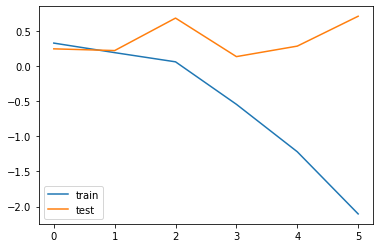

In [53]:
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

5007/5007 [==============================] - 22s 4ms/step
Train: 0.917, Test: 0.892


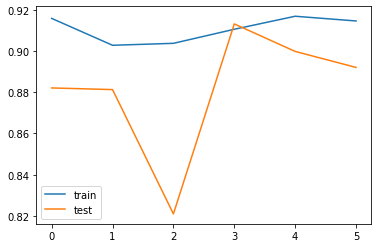

In [57]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [0]:
model.save("model.h5")

In [55]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [58]:
test_sample1 = 'This drama is horrible.'
test_sample2 = 'Love the actors and music. Best drama in 2019'
test_sample3 = 'I think this drama is so-so. Maybe a 5/10'
test_sample4 = 'Enjoyed it thoroughly. Although people say the plot progressed very slowly, it hooked me throughout the dramas.'
test_samples = [test_sample1, test_sample2, test_sample3, test_sample4]

test_samples_tokens = tokenizer.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

model.predict(x=test_samples_tokens_pad)

array([[0.9999666],
       [0.9992404],
       [0.9743017],
       [0.997743 ]], dtype=float32)

The results are not good at all. The model is unable to differentiate a positive sentiment from a negative one. To improve the model, we can...

## Repeat with binary sentiment and adding dropout

Instead of a multiclass classification (positive, negative, neutral), we can turn it into a binary classification problem (positive, negative). 

In addition, to reduce overfitting, we can add a dropout layer.

In [63]:
df['sentiment'] = [1 if i == 1 else 0 for i in df['sentiment']]
df['sentiment'].unique()

array([1, 0])

In [0]:
# Creating the training and validation sets
X_train, X_test, y_train, y_test = train_test_split(pad, df.sentiment, test_size = 0.20, random_state = 42)

In [0]:
from keras.layers import Dropout

In [0]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [72]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    callbacks=[es, mc])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20027 samples, validate on 5007 samples
Epoch 1/15
20027/20027 [==============================] - 497s 25ms/step - loss: 0.2489 - accuracy: 0.9242 - val_loss: 0.2115 - val_accuracy: 0.9291

Epoch 00001: val_accuracy improved from -inf to 0.92910, saving model to best_model.h5
Epoch 2/15
20027/20027 [==============================] - 499s 25ms/step - loss: 0.1713 - accuracy: 0.9374 - val_loss: 0.1966 - val_accuracy: 0.9329

Epoch 00002: val_accuracy improved from 0.92910 to 0.93289, saving model to best_model.h5
Epoch 3/15
20027/20027 [==============================] - 497s 25ms/step - loss: 0.1220 - accuracy: 0.9553 - val_loss: 0.1938 - val_accuracy: 0.9353

Epoch 00003: val_accuracy improved from 0.93289 to 0.93529, saving model to best_model.h5
Epoch 4/15
20027/20027 [==============================] - 497s 25ms/step - loss: 0.1079 - accuracy: 0.9605 - val_loss: 0.2366 - val_accuracy: 0.9033

Epoch 00004: val_accuracy did not improve from 0.93529
Epoch 5/15
20027/20027 [=====

5007/5007 [==============================] - 22s 4ms/step
Train: 0.990, Test: 0.928


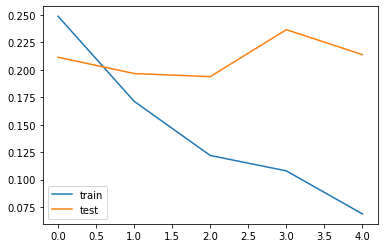

In [73]:
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

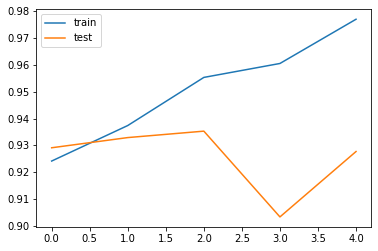

In [74]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [75]:
model.predict(x=test_samples_tokens_pad)

array([[0.7383321 ],
       [0.99972564],
       [0.7311709 ],
       [0.99955946]], dtype=float32)

Now, there is at least 0.2 probability difference between the positive and negative sentiment. With the sigmoid function, it is possible to set the threshold to higher than 0.5, such as 0.8 to classify a positive sentiment as positive. This higher treshold could be due to the significantly higher proportion of positive reviews compared to negative ones.



## Increasing patience

Another way to reduce the validation loss is to increase the number of training epochs. We could increase patience from 2 to 4. 

In [81]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
mc = ModelCheckpoint('best_model_soft.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    callbacks=[es, mc])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20027 samples, validate on 5007 samples
Epoch 1/15
20027/20027 [==============================] - 481s 24ms/step - loss: 0.2442 - accuracy: 0.9243 - val_loss: 0.2121 - val_accuracy: 0.9283

Epoch 00001: val_accuracy improved from -inf to 0.92830, saving model to best_model_soft.h5
Epoch 2/15
20027/20027 [==============================] - 492s 25ms/step - loss: 0.1708 - accuracy: 0.9390 - val_loss: 0.1928 - val_accuracy: 0.9339

Epoch 00002: val_accuracy improved from 0.92830 to 0.93389, saving model to best_model_soft.h5
Epoch 3/15
20027/20027 [==============================] - 480s 24ms/step - loss: 0.1373 - accuracy: 0.9521 - val_loss: 0.1968 - val_accuracy: 0.9395

Epoch 00003: val_accuracy improved from 0.93389 to 0.93948, saving model to best_model_soft.h5
Epoch 4/15
20027/20027 [==============================] - 469s 23ms/step - loss: 0.0880 - accuracy: 0.9696 - val_loss: 0.2093 - val_accuracy: 0.9297

Epoch 00004: val_accuracy did not improve from 0.93948
Epoch 5/15
200

5007/5007 [==============================] - 22s 4ms/step
Train: 0.993, Test: 0.931


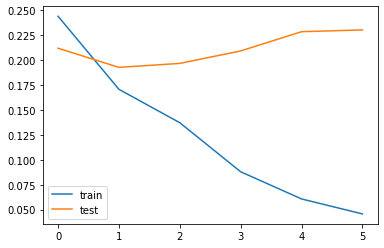

In [82]:
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

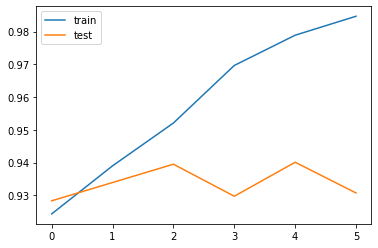

In [83]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [84]:
model.predict(x=test_samples_tokens_pad)

array([[0.25155318],
       [0.9995559 ],
       [0.77527547],
       [0.9981889 ]], dtype=float32)

Although there does not seem to be a difference in the loss and accuracy scores, we can see a stark difference in the probability for _test_sample1_. In our previous training, the probability was 0.7383321, which was rather similar to _test_sample3_, a somewhat neutral statement. Since the probability is much closer to 0 than to 1, we can say with confidence that _test_sample1_ has a negative sentiment. 

Similarly, this model gives us a good sense of the probability of a neutral sentiment. In this prediction, the probability for _test_sample3_ was 0.77527547, which was approximately 0.2 lower than the positive review and 0.5 higher than the negative review.